In [ ]:
##Generative Adversarial Network

In [1]:
#create dataloaders
from random import randint as ri
import torch as torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

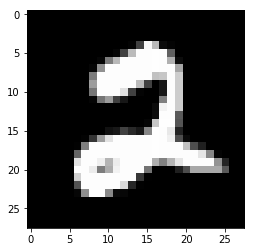

       two        two       five       eight


In [13]:
#check if data is loaded properly
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0]))
# print labels
print(' '.join('      %4s' % classes[labels[j]] for j in range(4)))

In [5]:
#Generator model 
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (5), stride= 4),      #Apply a convolutional block
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = (14), stride= 1),
        )
        
    def forward(self, x):
        x = self.block(x);
        
        return abs(x%1)

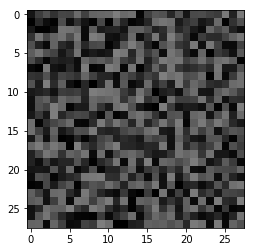

torch.Size([4, 1, 28, 28])

In [22]:
gen = Generator()
gen_ip = torch.randn(4,32,10,10)
gen_ip.shape
a = gen(gen_ip)
imshow(torchvision.utils.make_grid(a[0] ))
a.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


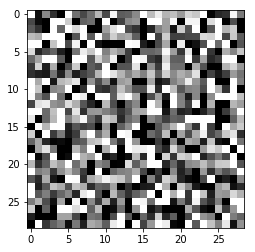

ValueError: axes don't match array

In [16]:
imshow(torchvision.utils.make_grid(torch.randn(1,1,29,29)))
imshow(images)

In [17]:
#Discriminator model 

class Discriminator(nn.Module):
    def __init__(self):
        
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(1, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
        )
        
        self.fc1 = nn.Linear( 24*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)         

    def forward(self, x):
        x = self.block(x);
        x = x.view(-1,  24*4)
        x = F.relu(self.fc1(x));
        x = F.relu(self.fc2(x));
        x = self.fc3(x);
        #_, predicted = torch.max(x,1);
        return x


In [ ]:
#Create an instance of the generator and discriminator
gen = Generator()
dis = Discriminator()

In [ ]:
#create optimization function and loss function for both generator and discriminator
import torch.optim as optim

criteriondis = nn.CrossEntropyLoss()
criteriongen = nn.MSELoss()
gen_optimizer = optim.Adam(gen.parameters(), lr=0.002, betas = (0.5,0.999))
dis_optimizer = optim.Adam(dis.parameters(), lr = 0.00001, betas = (0.5,0.999))

In [ ]:
#Load previously trained weights:
numpygen_conv1_weight = np.load('parameters/numpygen_conv1_weight.npy')
numpygen_conv1_bias   = np.load('parameters/numpygen_conv1_bias.npy')
numpygen_bn_weight    = np.load('parameters/numpygen_bn_weight.npy')
numpygen_bn_bias      = np.load('parameters/numpygen_bn_bias.npy')
numpygen_conv2_weight = np.load('parameters/numpygen_conv2_weight.npy')
numpygen_conv2_bias   = np.load('parameters/numpygen_conv2_bias.npy')
numpydis_conv1_weight = np.load('parameters/numpydis_conv1_weight.npy')
numpydis_conv1_bias   = np.load('parameters/numpydis_conv1_bias.npy')
numpydis_bn_weight    = np.load('parameters/numpydis_bn_weight.npy')
numpydis_bn_bias      = np.load('parameters/numpydis_bn_bias.npy')

#Write to the models
#gen_conv1_weight = gen.block[0].weight
#gen_conv1_bias = gen.block[0].bias
#gen_bn_weight = gen.block[2].weight
#gen_bn_bias = gen.block[2].bias
#gen_conv2_weight = gen.block[3].weight
#gen_conv2_bias = gen.block[3].bias
#numpygen_conv1_weight = gen_conv1_weight.data.numpy()
#numpygen_conv1_bias = gen_conv1_bias.data.numpy()
#numpygen_bn_weight = gen_bn_weight.data.numpy()
#numpygen_bn_bias = gen_bn_bias.data.numpy()
#numpygen_conv2_weight = gen_conv2_weight.data.numpy()
#numpygen_conv2_bias = gen_conv2_bias.data.numpy()
#discriminator
#dis_conv1_weight = dis.block[0].weight
#dis_conv1_bias = dis.block[0].bias
#dis_bn_weight = dis.block[3].weight
#dis_bn_bias = dis.block[3].bias
#numpydis_conv1_weight = dis_conv1_weight.data.numpy()
#numpydis_conv1_bias = dis_conv1_bias.data.numpy()
#numpydis_bn_weight = dis_bn_weight.data.numpy()
#numpydis_bn_bias = dis_bn_bias.data.numpy()

In [ ]:
#Train the GAN
for epoch in range(1):

    running_loss_real = 0.0
    running_loss_fake = 0.0
    running_loss_gen  = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        real_images, real_labels = data
        ones = torch.ones(real_labels.shape,dtype = torch.int64)
        zeros = torch.zeros(real_labels.shape,dtype = torch.int64)
        gen_ip = torch.randn((4,32,10,10))


        # zero the parameter gradients
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # forward + backward + optimize
        gen_op = gen(gen_ip)
        dis_op = dis(real_images)
        
        #Minimize discriminator loss against ones
        real_output = dis(real_images)
        real_loss = criteriondis(real_output.float(), ones)
        real_loss.backward()
        dis_optimizer.step()
        
        #Minimize discriminator loss against zeros
        fake_images = gen(gen_ip)
        fake_output = dis(fake_images)
        fake_loss = criteriondis(fake_output.float(), zeros)
        fake_loss.backward()
        dis_optimizer.step()
        
        #Minimize generator loss
        fake_images = gen(gen_ip)
        gen_loss = criteriongen(fake_images.float(), real_images.float())
        gen_loss.backward()
        gen_optimizer.step()

        # print statistics
        running_loss_real += real_loss.item()
        running_loss_real += fake_loss.item()
        running_loss_gen += gen_loss.item()
        if i%200 == 199:
            print('.')
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('Epoch: %d | No of images: %5d | real_loss: %.3f | fake_loss: %.3f | gen_loss: %.3f' %
                  (epoch + 1, i + 1, running_loss_real / 2000, running_loss_fake / 2000, running_loss_gen / 2000))
            running_loss_real = 0.0
            running_loss_fake = 0.0
            running_loss_gen  = 0.0

print('Finished Training')

In [ ]:
temp = gen(gen_ip)
imshow(torchvision.utils.make_grid(temp[0]))

In [ ]:
#obtain the learned weights and biases

#generator
gen_conv1_weight = gen.block[0].weight
gen_conv1_bias = gen.block[0].bias
gen_bn_weight = gen.block[2].weight
gen_bn_bias = gen.block[2].bias
gen_conv2_weight = gen.block[3].weight
gen_conv2_bias = gen.block[3].bias
numpygen_conv1_weight = gen_conv1_weight.data.numpy()
numpygen_conv1_bias = gen_conv1_bias.data.numpy()
numpygen_bn_weight = gen_bn_weight.data.numpy()
numpygen_bn_bias = gen_bn_bias.data.numpy()
numpygen_conv2_weight = gen_conv2_weight.data.numpy()
numpygen_conv2_bias = gen_conv2_bias.data.numpy()
#discriminator
dis_conv1_weight = dis.block[0].weight
dis_conv1_bias = dis.block[0].bias
dis_bn_weight = dis.block[3].weight
dis_bn_bias = dis.block[3].bias
numpydis_conv1_weight = dis_conv1_weight.data.numpy()
numpydis_conv1_bias = dis_conv1_bias.data.numpy()
numpydis_bn_weight = dis_bn_weight.data.numpy()
numpydis_bn_bias = dis_bn_bias.data.numpy()


#save the parameters
np.save('parameters/numpygen_conv1_weight', numpygen_conv1_weight)
np.save('parameters/numpygen_conv1_bias', numpygen_conv1_bias)
np.save('parameters/numpygen_bn_weight', numpygen_bn_weight)
np.save('parameters/numpygen_bn_bias', numpygen_bn_bias)
np.save('parameters/numpygen_conv2_weight', numpygen_conv2_weight)
np.save('parameters/numpygen_conv2_bias', numpygen_conv2_bias)
np.save('parameters/numpydis_conv1_weight', numpydis_conv1_weight)
np.save('parameters/numpydis_conv1_bias', numpydis_conv1_bias)
np.save('parameters/numpydis_bn_weight', numpydis_bn_weight)
np.save('parameters/numpydis_bn_bias', numpydis_bn_bias)


In [ ]:
torch.save(gen.state_dict(), 'parameters/gen')
torch.save(dis.state_dict(), 'parameters/dis')